In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time

from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms as tfs
torch.manual_seed(42)

from glob import glob

from sklearn.model_selection import train_test_split

import multiprocessing as mp 
from multiprocessing import freeze_support

import argparse
from copy import deepcopy

In [2]:
class CNN(nn.Module):
    
    def __init__(self, model_code, in_channels, out_dim, act, use_bn):
        super(CNN, self).__init__()
        
        if act == 'relu':
            self.act = nn.ReLU()
        elif act == 'sigmoid':
            self.act = nn.Sigmoid()
        elif act == 'tanh':
            self.act = nn.TanH()
        else:
            raise ValueError("Not a valid activation function code")
        
        self.layers = self._make_layers(model_code, in_channels, use_bn)
        self.classifer = nn.Sequential(nn.Linear(8192, 1024),
                                       self.act,
                                       nn.Linear(1024, out_dim))
        
    def forward(self, x):
        x = self.layers(x)
        x = x.view(x.size(0), -1)
        x = self.classifer(x)
        return x
        
    def _make_layers(self, model_code, in_channels, use_bn):
        layers = []
        for x in cfg[model_code]:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels=in_channels,
                                     out_channels=x,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1)]
                if use_bn:
                    layers += [nn.BatchNorm2d(x)]
                layers += [self.act]
                in_channels = x
        return nn.Sequential(*layers)

In [3]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
}

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = CNN('VGG13', 3, 360, 'relu', True)
model.to(device)

model.load_state_dict(torch.load('D:/lomin/weight/128-0001-13-177-7690.pt'))

<All keys matched successfully>

In [5]:
class ProImageTransform():
    
    def __init__(self):
        self.im_aug = tfs.Compose([
            tfs.Resize(256),
            tfs.CenterCrop(128),
            tfs.ToTensor(),
            tfs.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
            ])

    def __call__(self, img):

        x = self.im_aug(img)
        return x

In [6]:
class Pro_Img_Dataset(Dataset):
    
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path).convert('RGB') # 픽셀당 추가 알파 채널이 있다고 생각 하므로 채널이 3개가 아닌 4개입니다.
        img_transformed = self.transform(img)

        return img_transformed, img_path

In [7]:
DATA_PATH_PRO_LIST = []
DATA_PATH_PRO_LIST.extend(glob('./data/test_data/*.png'))
DATA_PATH_PRO_LIST.extend(glob('./data/test_data/*.jpg'))
pro_dataset = Pro_Img_Dataset(file_list=DATA_PATH_PRO_LIST,
                        transform=ProImageTransform())

pro_dataloader = DataLoader(pro_dataset,
                            batch_size=64)
partition = {}
partition['pro'] = pro_dataloader

In [8]:
def pro(net, partition):
    
    net.eval()
    
    current_preds = []
    img_path_list = []
    per = []
    with torch.no_grad():
        for data in partition['pro']:
            images, img_path = data
            images = images.cuda()

            outputs = net(images)
            for i in outputs.data:
                per.append( (max(i)/sum(i))*100000 )
            _, predicted = torch.max(outputs.data, 1)

            current_preds.extend(predicted)
            img_path_list.extend(img_path)

    return current_preds, img_path_list, per

In [9]:
if __name__ == '__main__':
    mp.freeze_support()
    predicted, img_path, per = pro(model, partition)
    
result_test = {}
result_test['predicted'] = predicted
result_test['img_path'] = img_path
result_test['per'] = per

0 359 tensor(62.0407, device='cuda:0')


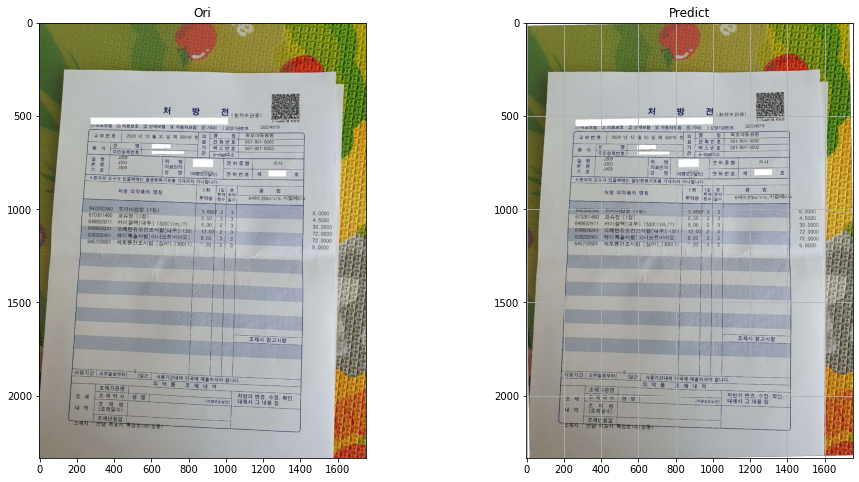

In [12]:
for i, a in enumerate(result_test['predicted']):
    print(i, a.item(), result_test['per'][i])
    img = result_test['img_path'][i]

    fig, ax = plt.subplots(1, 2, figsize=(16,8))

    ax[0].imshow(Image.open(img))
    ax[1].imshow(Image.open(img).rotate(-a.item()))
    ax[0].set_title('Ori')
    ax[1].set_title('Predict')
    ax[1].grid()
    plt.show()
    break